In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.patches as mpatches

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'code')
from help_funcs import *

In [3]:
import matplotlib

matplotlib.rcParams.update({'font.size': 18})

In [100]:
def periodic_distance(p1, p2, L=1.0):
    """
    Calculates the periodic distance between two points on a 1x1 2-dimensional plane.

    Parameters
    ----------
    p1 : numpy array
        The first point, with shape (2,).
    p2 : numpy array
        The second point, with shape (2,).
    L : float
        The length of the periodic boundary, default value is 1.0.

    Returns
    -------
    distance : float
        The periodic distance between two points.
    """
    delta = np.abs(p1 - p2)
    delta = np.where(delta > L/2, L - delta, delta)
    return np.sqrt(np.sum(delta**2))

import scipy.stats
def getStimRateMeans(exc_spikes, exc_positions, rates=False, nsecs = 5, binlen = 60):
    # store the control times and the chr2 stimulation times
    control_times = []
    chr_times = []
    ii = 0
    is_control = True
    while True:
        start_time = ii * 500 + 1000
        stop_time = start_time + binlen
        if stop_time > nsecs*1000: break
        if is_control:
            control_times.append(start_time)
        else:
            chr_times.append(start_time)   
        ii += 1
        if is_control:
            is_control = False
        else:
            is_control = True        
        
    assert len(control_times) == len(chr_times)
#     print("NTIMES:", control_times, chr_times)
    # compute the rates of the cells distal to the chr2 stimulus
    control_spikes = []
    chr_spikes = []
    center_pos = np.array([0.5,0.5])
    for ni in range(len(exc_positions)):
        pos_x, pos_y = exc_positions[ni,:]
        dist = np.sqrt((0.5-pos_x)**2 + (0.5-pos_y)**2)
        if dist > 0.25:
            continue
        nspikes = 0
        for tim in control_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+binlen]
            nspikes += len(aa)
        control_spikes.append(nspikes)

        nspikes = 0
        for tim in chr_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+binlen]
            nspikes += len(aa)
        chr_spikes.append(nspikes)
    control_rates = np.divide(control_spikes,(binlen/1000)*len(control_times)) # convert from spike count to rate
    chr_rates = np.divide(chr_spikes,(binlen/1000)*len(chr_times))
    ctrl_mean = np.mean(control_rates)
    chr2_mean = np.mean(chr_rates)
    
    ctrl_err = scipy.stats.sem(control_rates)
    chr2_err = scipy.stats.sem(chr_rates)
    
    if rates:
        return [ctrl_mean, chr2_mean, ctrl_err, chr2_err, control_rates, chr_rates]
    else:
        return [ctrl_mean, chr2_mean, ctrl_err, chr2_err]
    

def getSpontMedians(all_spikes, start_time = 1000., stop_time = 10000.):
    
    exc_spikes = all_spikes[:8000]
    pv_spikes = all_spikes[8000:9000]
    sst_spikes = all_spikes[9000:]
    
    tlen = (stop_time - start_time)/1000.
    
    exc_nspikes = []
    for spikes in exc_spikes:
        aa = spikes[spikes > start_time ]
        aa = aa [aa < stop_time]
        exc_nspikes.append(len(aa)/tlen)
        
    pv_nspikes = []
    for spikes in pv_spikes:
        aa = spikes[spikes > start_time ]
        aa = aa [aa < stop_time]
        pv_nspikes.append(len(aa)/tlen)
        
    sst_nspikes = []
    for spikes in sst_spikes:
        aa = spikes[spikes > start_time ]
        aa = aa [aa < stop_time]
        sst_nspikes.append(len(aa)/tlen)
        
    return np.median(exc_nspikes), np.median(pv_nspikes), np.median(sst_nspikes)

In [101]:
import numpy as np
from scipy.optimize import curve_fit

# naka-rushton = (m+((Rm.*(x.^n))./((x.^n) + (c50.^n)))))
# parameter = [Rm, n, c50, m]
# p0 = [150, 5, 0.1, 50]
# Upper = [250, 30, 0.26, 200]
# Lower = [0, 0, 0.04, 0]
p0 = [50, 150, 5, 0.1] 
Upper = [200, 250, 15, 0.2]
# Lower = [0, 0, 0, 0.04]
Lower = [0, 0, 0, 0.05]
bounds = (Lower, Upper)

def naka_rushton(x, m, C, n, k):
    return m + C * (x**n) / (x**n + k**n)

def fit_naka_rushton(x, y, sigma=None, p0 = p0, bounds=bounds):
    params, cov = curve_fit(naka_rushton, x, y, bounds=bounds, sigma=sigma, p0=p0, maxfev = 1000000)
    return params, cov


# def naka_rushton(x, m, C, n):
#     return m + C * (x**n) / (x**n + 0.1**n)

# def fit_naka_rushton(x, y, sigma=None, p0 = [4., 2.0, 2.0]):
#     params, cov = curve_fit(naka_rushton, x, y, sigma=sigma, p0=p0, maxfev = 1000000)
#     return params, cov

# x = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
# y = np.array([0.1, 0.15, 0.3, 0.6, 0.8])

# C, n, k = fit_naka_rushton(contrasts, y)
# print("C =", C)
# print("n =", n)
# print("k =", k)


In [102]:
def get_slope(m,C,n,k):
    cvals = np.arange(0.02,0.33,0.01)
    yvals = naka_rushton(cvals, m, C, n, k)
    
    slopes = []
    for i in range(1, len(cvals)):
        slopes.append((yvals[i]-yvals[i-1])/0.01)
    maxslope = np.max(slopes)
    return maxslope, cvals[slopes.index(maxslope)]

3.532124451515465 1.2477054708892894 1.9956074810282889 0.17494917305850108
8.017027321587467 6.1360245093701415 6.558653122329616 4.6190758712123525 8.017027321587467


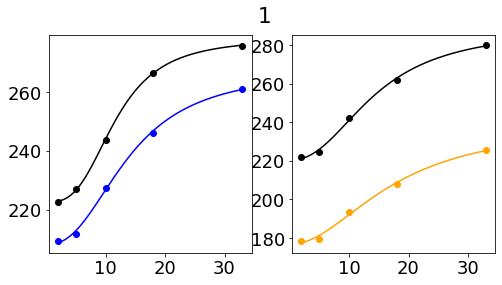

1
3.2981500212595622 1.8374510301024949 1.4899003057034348 0.19999999999999998
6.440449280932281 7.158523973562314 6.64174214974107 5.594531722832574 7.158523973562314


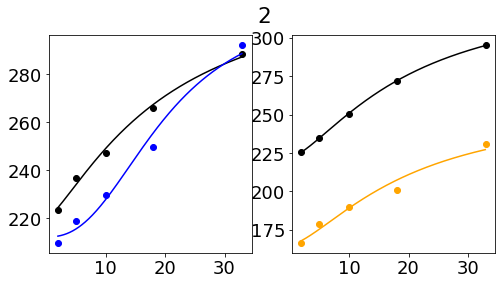

2
3.6673943702823406 1.4513369005952224 2.84100212071736 0.19999999999427157
8.835564973381338 12.264942940554402 14.151068003667788 5.84586603786823 14.151068003667788


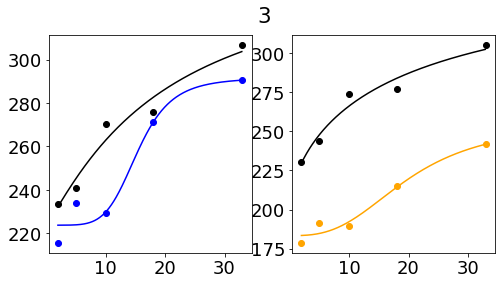

3
3.341967410915421 1.765299791388511 1.2756091620285688 0.19999999999999998
12.037304816932437 12.507931397092342 12.740829583996138 5.664269810028433 12.740829583996138


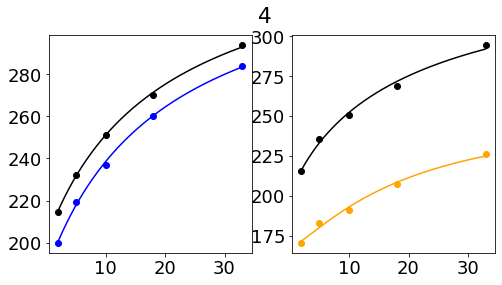

4
3.7066410404701644 1.2268113845944977 2.7871741442044624 0.19999999999999973
6.83448702770324 5.458268865230043 7.150875026275028 4.870936974274187 7.150875026275028


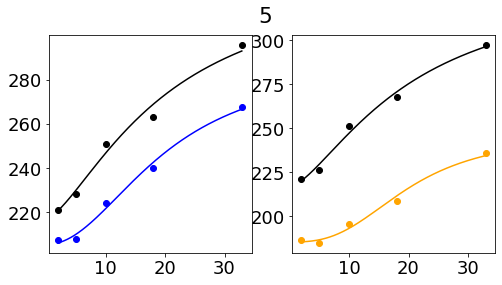

5
3.3372672350931265 1.2724774853040703 1.9895493752490006 0.12538951957022387
15.226424564832719 7.281773377752021 9.025034277531674 6.56024211316355 15.226424564832719


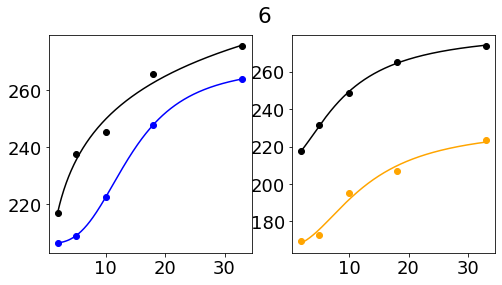

6
3.393983984068634 1.2437860530162772 2.976611516248432 0.15461594715517743
8.650602704362775 8.24585506113591 8.26778422228207 6.702829760925599 8.650602704362775


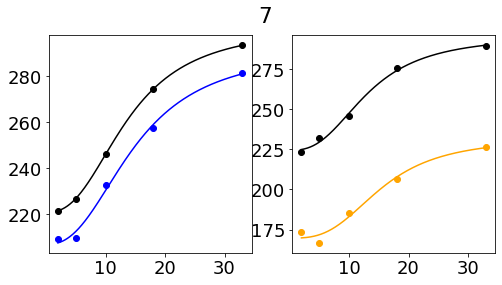

7
3.452575863154131 0.9703283612751729 1.446130399851745 0.061315088864333886
7.765172714866786 5.063244041923731 6.151157953334696 9.428507774609507 9.428507774609507


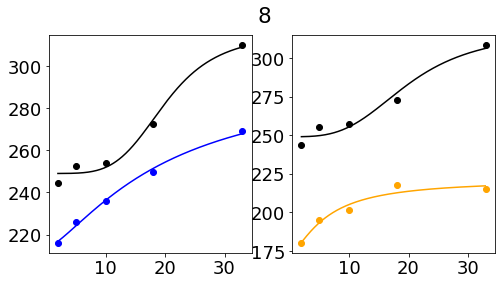

8
3.417437134577611 0.977205283282412 4.651606752213236 0.1418790784964966
6.152605573627223 7.16628629347813 7.816368155507281 8.32316151159569 8.32316151159569


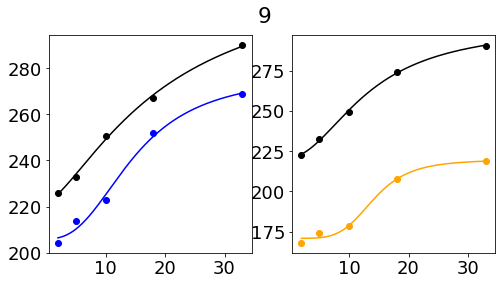

9
3.393597483681952 1.5181722569081255 2.144219861605074 0.19999999999999993
7.63970765109514 6.423787163610584 6.327203822561511 5.099329261373686 7.63970765109514


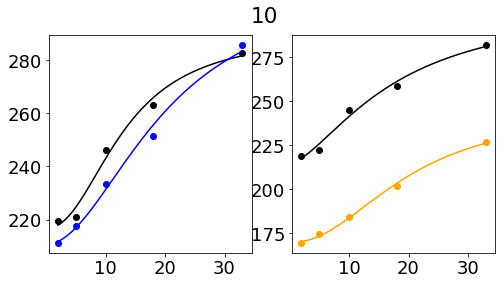

10
3.5229085098709234 1.3231448373002261 3.817474816418 0.19999999999999998
7.678138135831336 6.637860323171463 8.28870304375302 6.760402068851112 8.28870304375302


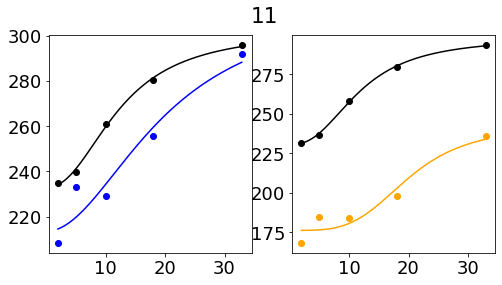

11
3.3935361168187512 1.1546256261946415 2.7709006131061313 0.14797165539692825
7.435937355279343 10.059703266820641 7.279130412968549 6.164764402753331 10.059703266820641


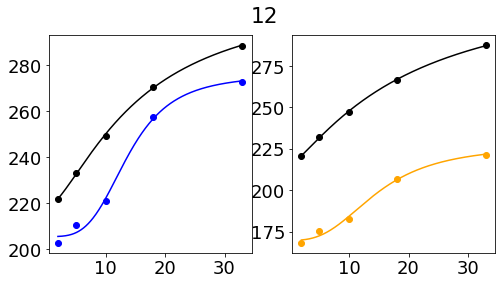

12
3.5047926763450676 0.8614598094332451 4.339665511414867 0.10654516831767269
6.964839257650279 10.908910347238532 7.040729069379381 9.21511687668315 10.908910347238532


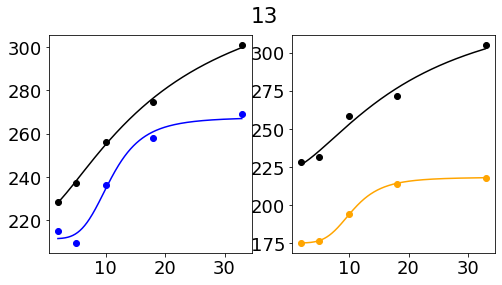

13
3.4258226026586023 1.7393868820566725 2.0643612172733548 0.19999999999999218
6.227354507184035 7.5310518156253 6.041873643216977 5.722720908004897 7.5310518156253


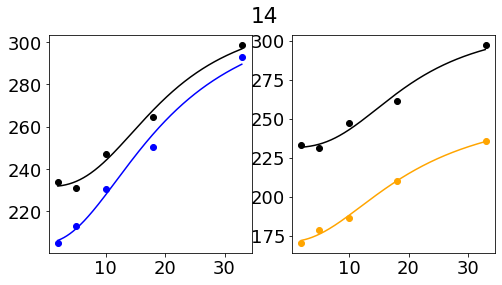

14
3.172069530119417 1.9321844099283367 1.8259607243385718 0.19999999999999998
7.223339014671382 7.267115132181168 6.4600613337480794 6.049838426356047 7.267115132181168


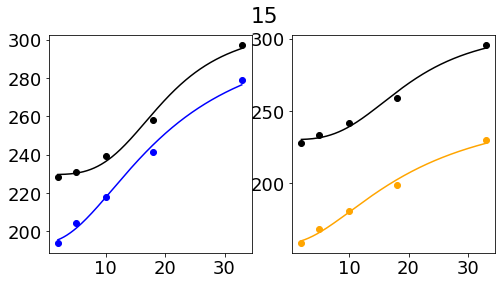

15
3.5870431372972065 1.123610178719412 4.6208812306023965 0.13964080430848005
5.499815576359168 6.817620821499304 5.932234939452741 9.70649889616162 9.70649889616162


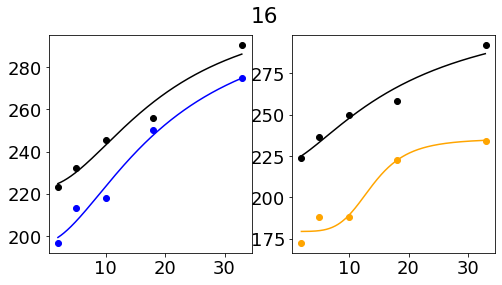

16
2.948246518619415 2.116408588727638 1.0041928338777728 0.19999999999678478
5.817525453297723 6.661683889554659 6.33900958625917 8.34307026632195 8.34307026632195


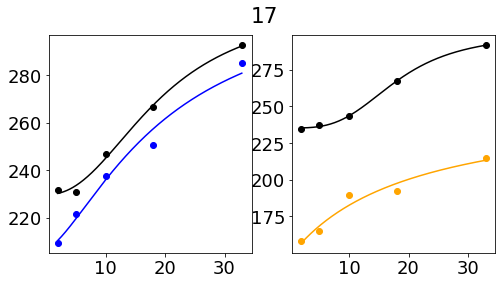

17
3.5666273391923635 1.7412397805734605 2.119654575712498 0.19999999999999998
8.480693264921868 7.212714413273602 8.089502359998235 5.812643266196282 8.480693264921868


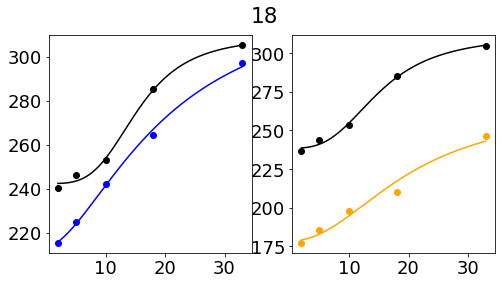

18
3.2477246174760537 1.8280446667468944 1.4090208749006274 0.19999999999999998
8.816321386878911 15.564251722882005 8.863491176796767 5.619591369446519 15.564251722882005


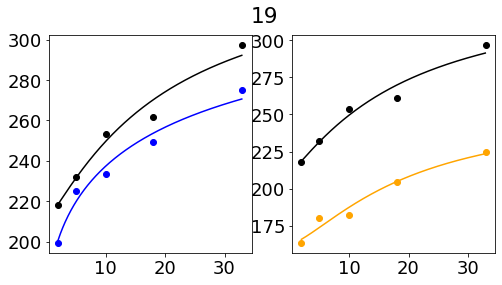

19
3.523967564962816 1.004504295039491 4.320882349363334 0.1619165717776745
23.310327002897946 11.062031521261417 5.751640336655939 7.061290355423733 23.310327002897946


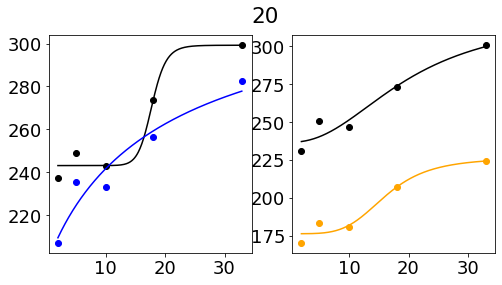

20
3.3740402572813215 1.9401012734051954 1.5814305649269669 0.19999999999999987
6.161609750087216 7.322408864640462 6.349979026007446 5.900901223347299 7.322408864640462


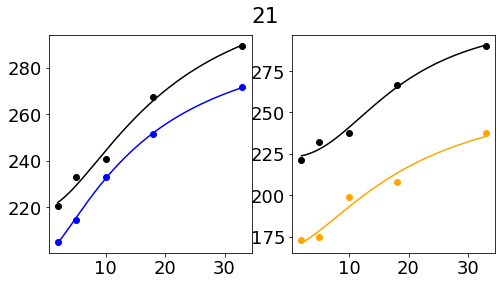

21
3.1839841479171294 1.6836322198741005 1.5237715554588827 0.18353193341968554
10.642758111407513 7.494104320872985 11.387804779664723 5.57992841068482 11.387804779664723


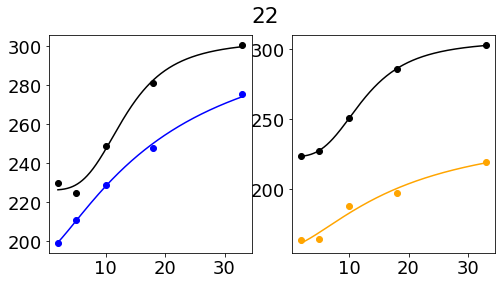

22
3.4879045908724353 1.6799674848825359 1.809728817118879 0.19999999999999993
6.985144948326205 7.435652573436968 11.866198750766621 5.242230352573962 11.866198750766621


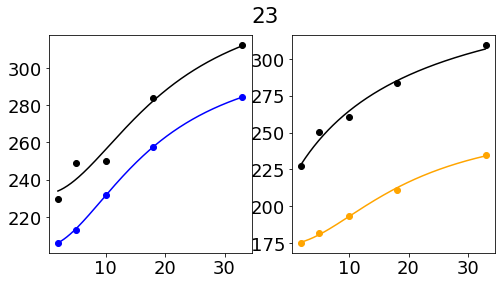

23
3.4957770391265495 1.5951861853421458 2.1474813887425612 0.18142418934861815
13.69884528836014 7.748839384481521 14.478321947314132 5.909802297011346 14.478321947314132


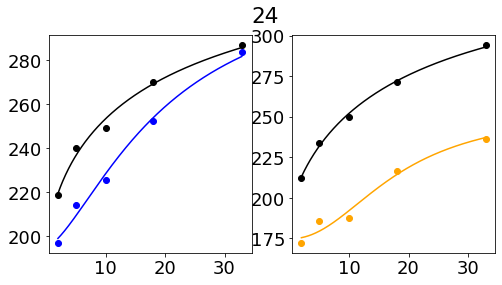

24
3.182644353571669 1.9011116963306016 0.9934682068476138 0.19999999999999998
5.205678750314213 12.930918769086608 5.003316664311797 7.544935556832932 12.930918769086608


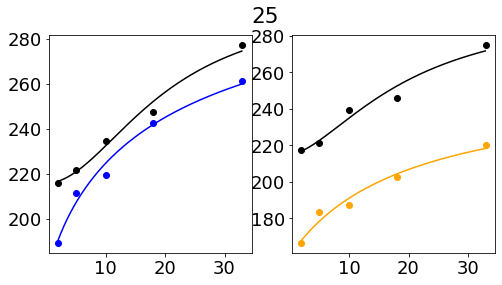

25
3.371880225441521 1.4585848449660528 2.7783490900349848 0.16758958687299857
9.452450139260105 6.568534049300112 8.460343285140137 6.889980034151533 9.452450139260105


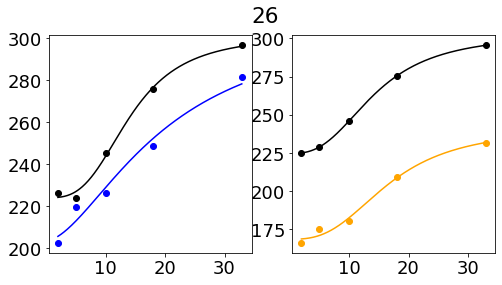

26
3.6296649720502274 1.3905805489006575 3.3719870336373314 0.19999999999999934
5.0972692585310675 7.255304061395229 5.392034610617635 6.401584808934846 7.255304061395229


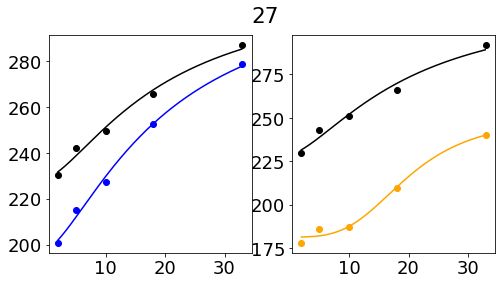

27
3.131995199912505 2.2480266505051354 1.4937745313977273 0.19999999999999957
5.672851748821195 7.928529239385984 5.699147276732663 6.841945981801745 7.928529239385984


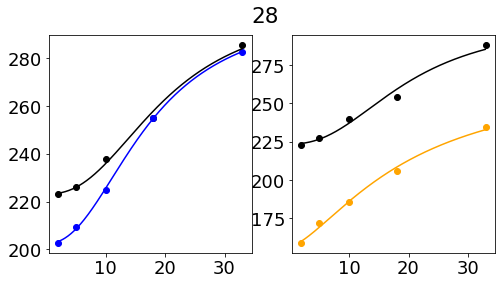

28
3.2722520362685485 1.5884937370346177 1.8382534855070538 0.19999999999999998
10.29160071613422 6.378913922277185 10.601396051759426 4.986172636832098 10.601396051759426


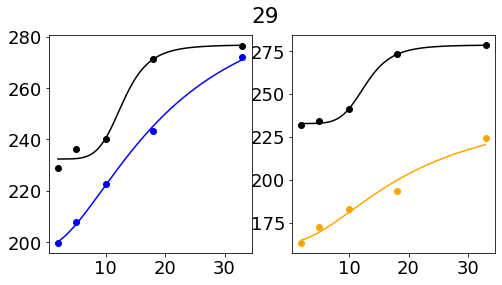

29
3.5100871818981094 1.3729037100051165 2.759225844824552 0.1340559947510177
8.213879618333397 9.296377698764235 8.030479138078128 8.057713112340936 9.296377698764235


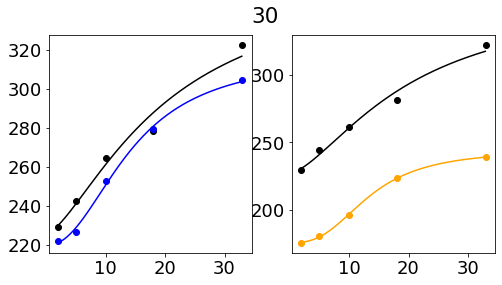

30
3.1009247654508423 2.2212873516981366 1.270801877591626 0.17137329662714246
7.399250851274353 9.407232836978974 8.221708568189978 8.339368566949101 9.407232836978974


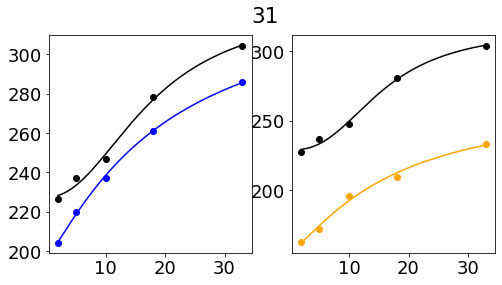

31
3.401413300106143 1.811399688324578 1.8708878602552117 0.19999999999999998
8.938941930930078 9.071569652857558 7.1875065233943936 5.721898224558641 9.071569652857558


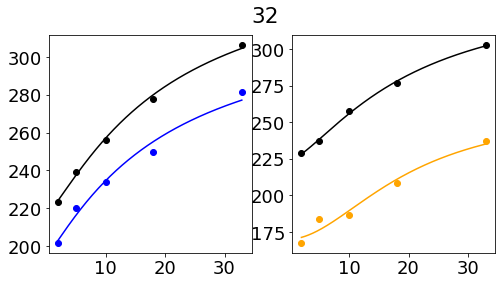

32
3.4782331904316357 1.5198048309468952 2.3543838941527184 0.19999999999999996
8.758325713396431 6.4404630481102565 8.076943957388316 5.385325647198691 8.758325713396431


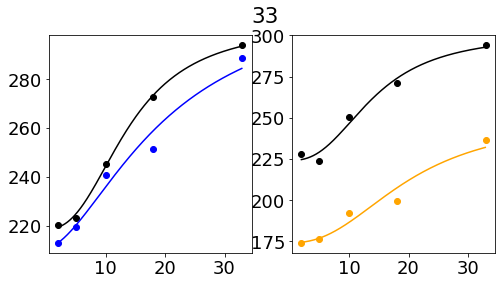

33
3.410449150809975 1.755918132731262 1.6282687587877835 0.19999999999999996
9.120316341548662 7.21676183700124 11.961626461777097 5.3568271111255505 11.961626461777097


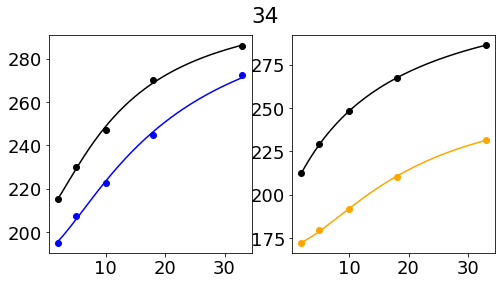

34
3.371860551647831 1.8177744175710255 1.493210250505536 0.18878780920092283
7.549543213346155 8.107167368501411 7.20210203807623 5.863389864341695 8.107167368501411


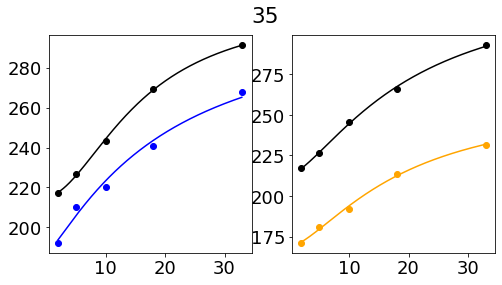

35
3.102044785912359 2.0069551431718735 1.19381865703324 0.19999999999999998
6.117134602964747 7.556264276543079 8.654663923537953 6.809287205378345 8.654663923537953


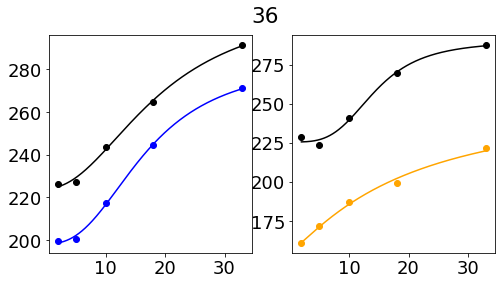

36
3.193532473085025 1.5732841102872661 1.977725218837266 0.1553782564413581
6.401976994084713 7.890405240126963 5.8980604589821795 6.531082422519763 7.890405240126963


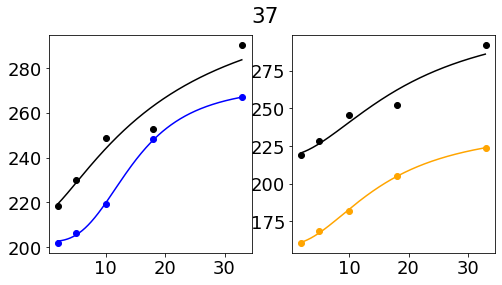

37
3.3309097673158563 1.443955906125799 2.3857145864991267 0.18829469168920573
14.019518669497621 6.27395652368028 14.50342156340394 5.471304784613196 14.50342156340394


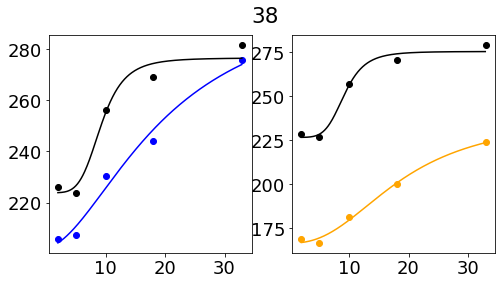

38
3.2728158028385965 1.3258834226850689 2.3959578834164916 0.1999999999999849
7.925314660799998 6.500920804976218 7.3069347964271 4.7471264920988965 7.925314660799998


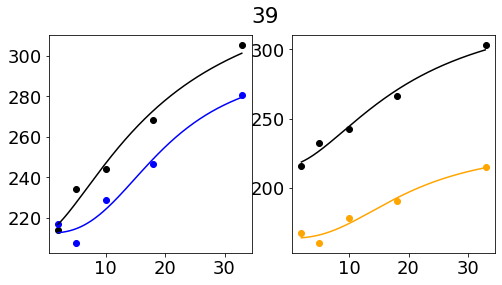

39
3.7503163524541985 0.9245847639248349 3.410030456980404 0.14203420164237
6.090786402887716 9.107527165217189 6.759762612544673 6.027272927676641 9.107527165217189


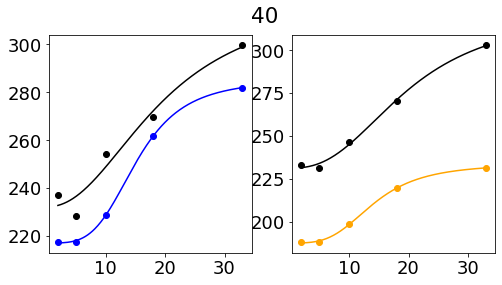

40
3.239590889423099 1.860633057863095 1.6716683082026047 0.19943267366155512
13.331456528888364 6.376772126884944 10.55219277266799 5.713834114677541 13.331456528888364


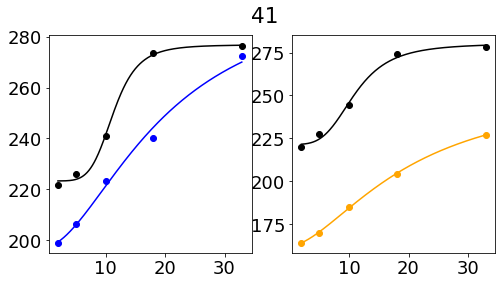

41
3.16202136269833 2.2430138295585333 1.3132609943017572 0.19999999999999948
13.782923010275994 12.487442220498313 7.21164242471497 7.084583323464955 13.782923010275994


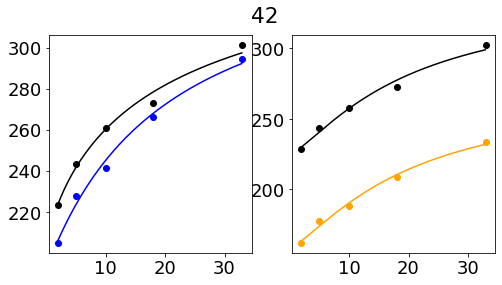

42
3.418040124577026 1.3116981412031317 2.2691080012628038 0.14450784281976142
8.825338195419441 6.390109655513321 9.085587239103354 6.2897640403213995 9.085587239103354


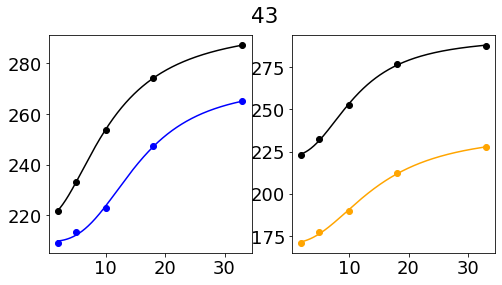

43
3.4362559850919507 1.978931984076536 2.00900542925365 0.19999999999999998
6.192703937562261 7.965398920890987 5.548227988495302 6.436354947321865 7.965398920890987


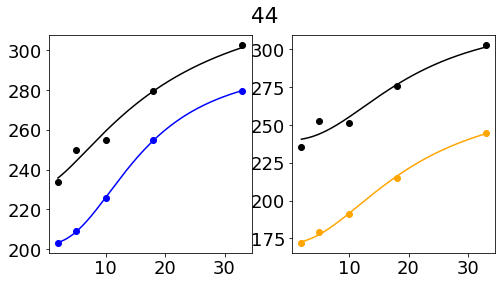

44
3.3322508432076936 1.2233910496861837 2.541677151469361 0.11505086169094854
6.4322259339875565 6.847027532220817 6.166778746760926 7.902659269930723 7.902659269930723


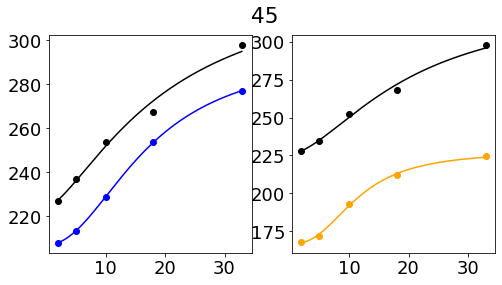

45
2.8749045772839295 2.4009075508655515 0.9932962461207021 0.19999999999999998
5.364486139153879 8.043656298133328 5.6246489810654055 9.529485039643282 9.529485039643282


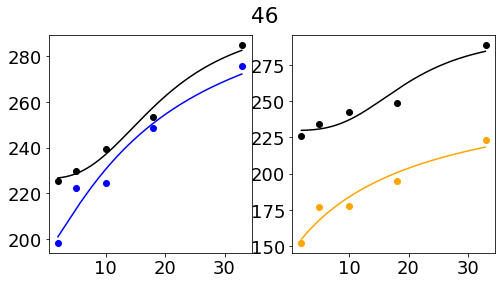

46
3.1963252521397307 1.7876827701100433 1.1466717384221925 0.1999999999999992
8.464813848586061 5.858663930792751 10.800920429374905 6.32750535633031 10.800920429374905


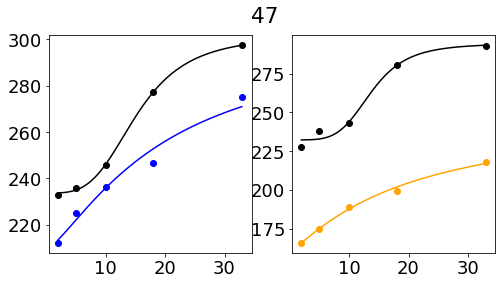

47
3.167311395348777 2.2105352341312425 1.2894107718981054 0.19999999999999998
6.073593948568945 8.544027336359061 5.95752597789474 7.040789914812562 8.544027336359061


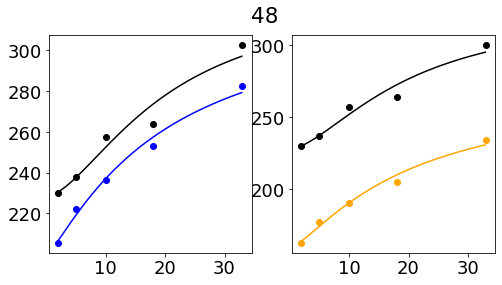

48
3.1617130960984143 1.4368017759975982 2.178113475198844 0.17883480778733976
5.695195285201571 6.7233147940061855 6.111745040213101 5.441182854511739 6.7233147940061855


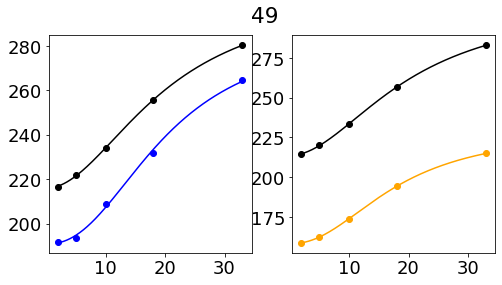

49
3.4631421371105757 1.5233034017057223 2.032185206893894 0.16570861531046618
6.874702723709625 6.897085879036791 8.535975977540389 6.007335323502883 8.535975977540389


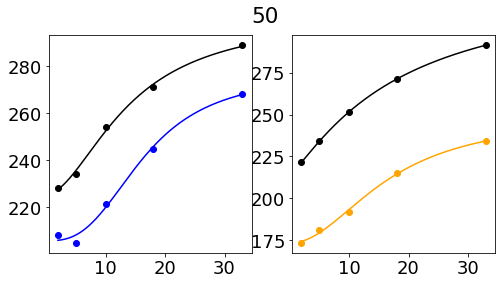

50
3.659415907804777 1.8089010546080695 1.9952786724604026 0.19999999999999998
10.734389787483511 7.5378089808119775 7.753582427173988 5.865582093359034 10.734389787483511


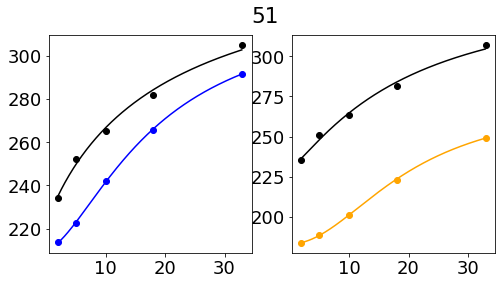

51
2.882799472807863 2.809380531893486 0.8414324495414002 0.19999999999991136
7.115384330163899 16.847794281176487 6.734233614074814 11.960523256959688 16.847794281176487


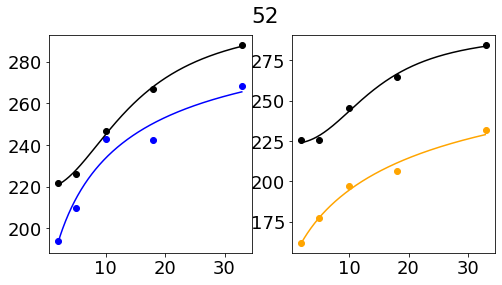

52
3.2250243938275402 1.7395658875399884 1.197441635985917 0.199999999999999
7.333461302431932 6.417844313151999 9.557962935395103 5.8821970555997805 9.557962935395103


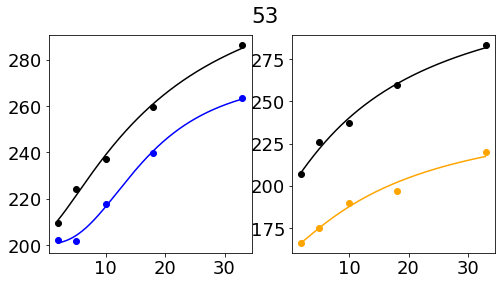

53
3.1184372311029063 1.744229115684612 1.6785756912744665 0.1999999999998514
5.13607391770341 6.584547735742774 5.218999517313083 5.34337642912015 6.584547735742774


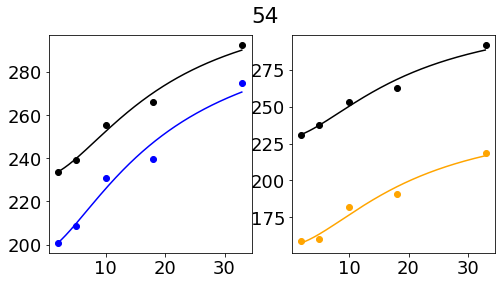

54
3.3282494629679893 1.4983483835626015 2.281286445056861 0.19999999999999993
7.35684226842217 6.8920793730949725 7.797697695292882 5.20807195513413 7.797697695292882


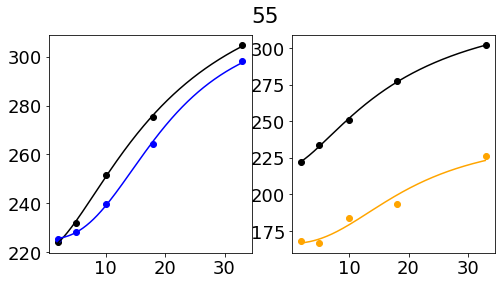

55
3.349422704492268 1.3865333057112093 2.2189981132918613 0.17505634668692252
6.71260077766771 6.529182577054993 8.645602243675654 5.418880439771545 8.645602243675654


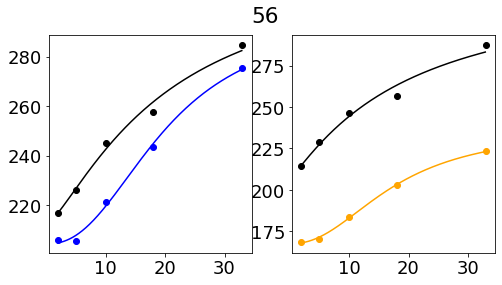

56
3.391875677461273 1.9830400712026408 1.928285789542573 0.19999999999999998
7.224608952241507 8.144827444861136 8.942692673927422 6.329737877376829 8.942692673927422


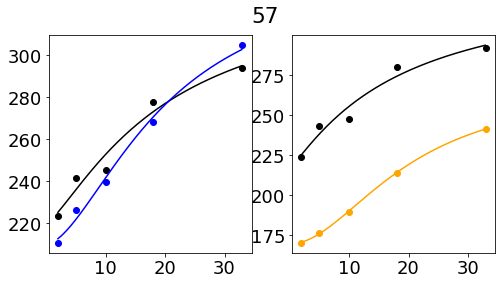

57
3.6641646196737736 1.2349177364221673 4.016007537549303 0.15431785074644397
6.468550465991729 7.616974131961918 6.872320705806967 8.537629581861772 8.537629581861772


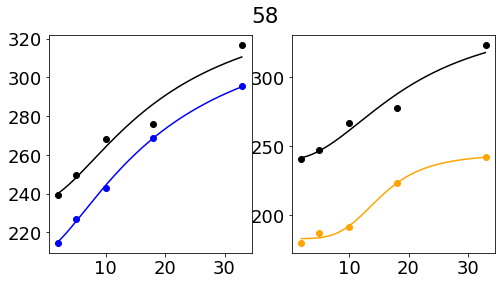

58
2.976550344632076 2.1025051118519236 0.9631976951409917 0.19999999999951232
5.6148629938402195 12.073107817092499 5.471271493962426 8.494247727019655 12.073107817092499


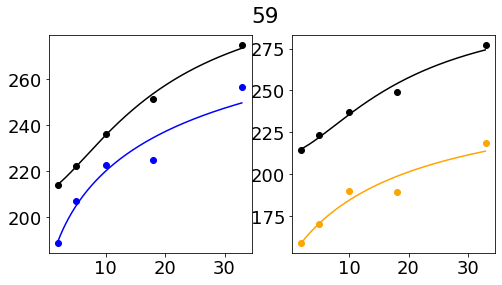

59
3.469918340855475 1.0796890863403015 3.061732362290181 0.1338737558998369
7.665167853735344 7.9461471875228895 7.290891914611386 6.864344052695737 7.9461471875228895


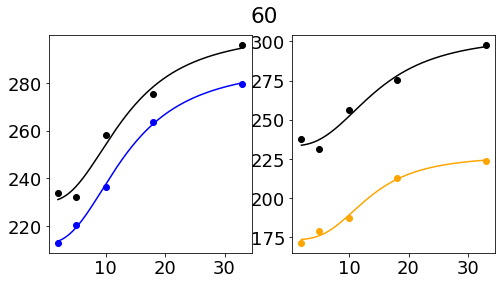

60
3.2576586532118283 1.7303972772516392 1.5638027207718304 0.18999918056329576
6.749065739378235 8.126313684118092 7.366716463145639 5.537378649690883 8.126313684118092


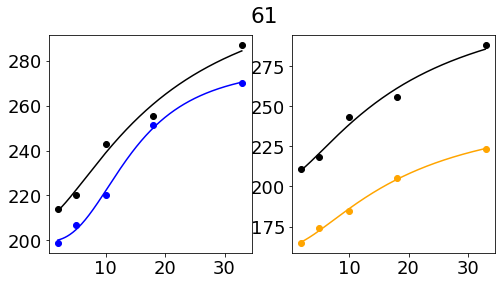

61
3.746348085383748 1.8960918098579371 1.6471961674740214 0.19999999999999998
7.9130152993259095 7.05988300833571 5.8904324101796135 5.794555890255371 7.9130152993259095


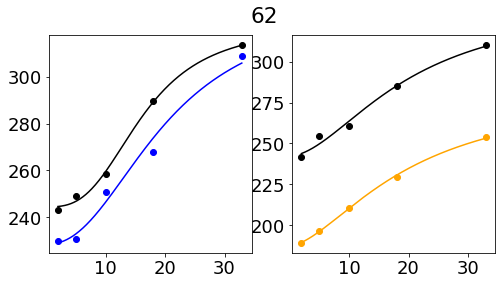

62
3.3542632577311724 1.6152076971365485 1.2234104899552432 0.19999999999999582
12.176155036940717 5.318216999743441 9.745904949948603 5.345340755403294 12.176155036940717


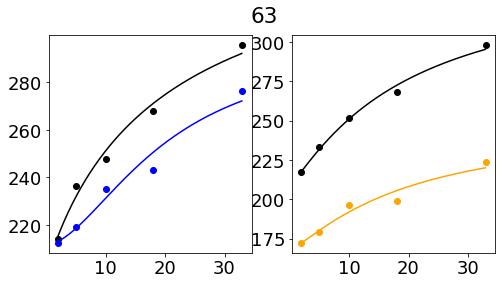

63
3.4027783813155144 1.3621842515665772 3.032174989364452 0.1274375171955362
6.286680716082049 9.530227985401396 6.759412224563199 9.01900467502692 9.530227985401396


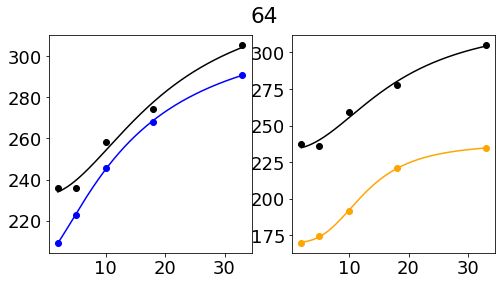

64
3.3669777833491388 1.8134146430874492 1.576456647602055 0.15609493970997268
7.215613787731634 9.709197431506222 6.795218463535235 7.053774920875178 9.709197431506222


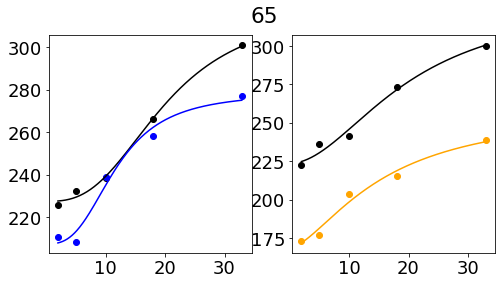

65
3.135126675141328 2.133795709187391 1.5322812215482455 0.19999999999999998
5.202215436289581 8.58035595883404 5.696166691940707 6.486703521364312 8.58035595883404


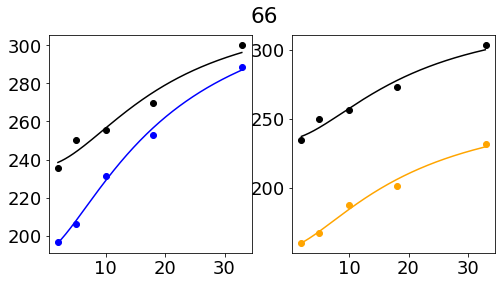

66
3.1691129792965578 1.7172881501889758 1.2380012379866887 0.18642987332625147
6.59592606900139 7.0385122564943 4.860309871169477 6.034205120993752 7.0385122564943


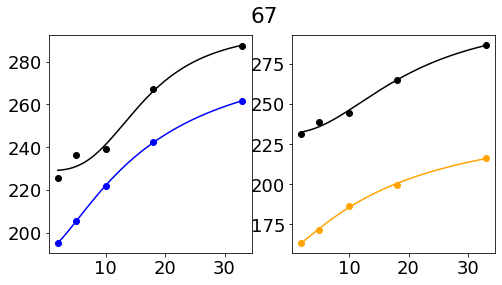

67
3.1925993215342183 1.5857656030061436 2.7091197150402544 0.19999999999999998
12.6124280093741 7.999904471296748 11.156130876425152 6.161168235393344 12.6124280093741


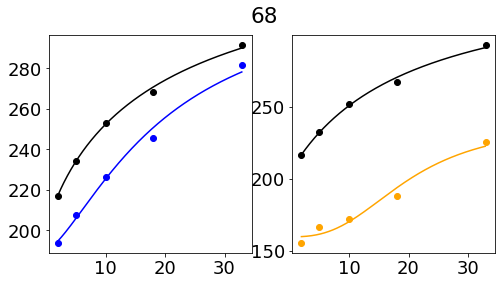

68
3.3177538949114926 1.6693513140760097 1.757450809906536 0.19999999999999998
6.571355203188656 7.5562529401731915 7.138267929194431 5.1702039917354 7.5562529401731915


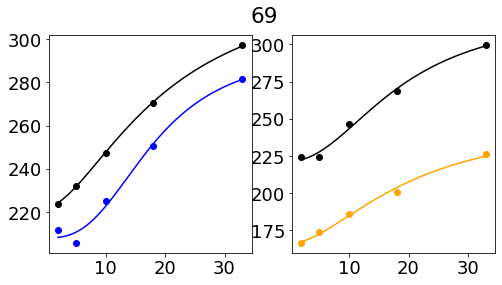

69
3.5629003594369997 1.191135849064799 6.359481200747253 0.12697940563826113
6.572558697793873 17.514207165177087 8.079545946155786 15.03597906021401 17.514207165177087


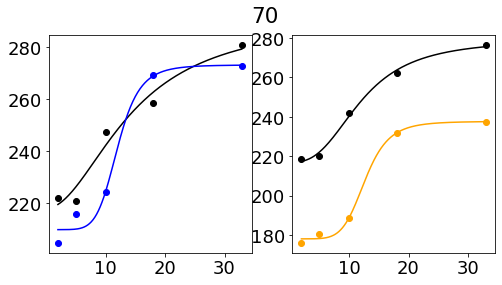

70
3.0881675043471155 2.549497109391714 1.1306702001134674 0.19999999999996962
6.223096100331027 8.163619423870028 6.5616205052665855 9.148102498622457 9.148102498622457


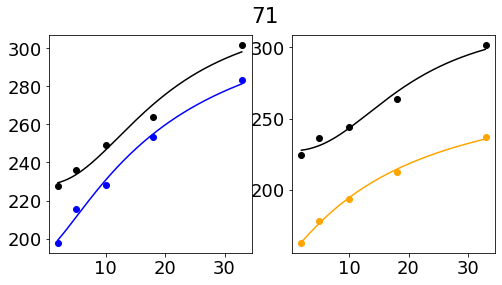

71
3.3281732476344863 1.7690747391482127 1.0065842597730392 0.19999999999999768
9.601684839688929 8.234922133412148 6.768301540765176 6.963196703456553 9.601684839688929


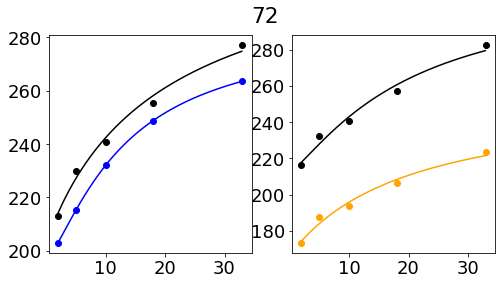

72
3.531322352445902 1.1756686800664302 3.4393968218263664 0.15178363710419537
7.608176451611026 6.100286846155978 7.992801482925227 7.238301085091292 7.992801482925227


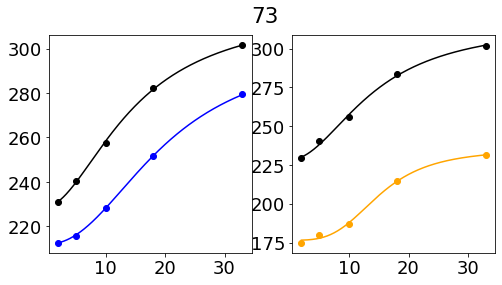

73
3.1664456999052097 2.0080981648024645 1.0647953896793458 0.1999999999999942
9.183008052350417 5.669813090073461 8.724796157594383 7.591824876154041 9.183008052350417


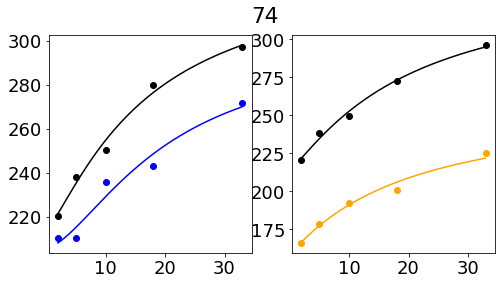

74
3.4220821156459773 1.087640920197747 2.709073396060088 0.12330400771488988
6.465786379394078 7.375498497909483 6.565495948487143 6.8516029816568125 7.375498497909483


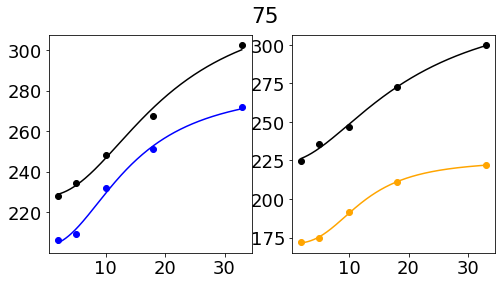

75
3.3736395900283513 1.4444482958692022 1.8806132170169547 0.19999999999999998
8.469991595245485 6.690574871790211 5.370319628085518 4.570952107033177 8.469991595245485


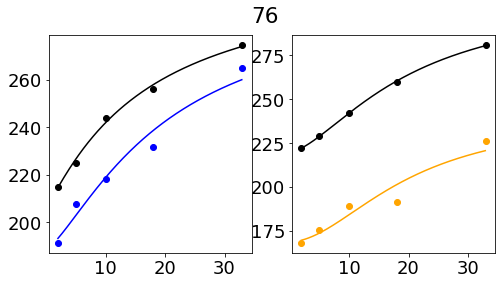

76
2.8770829268456777 2.310682927096813 0.9317344250938574 0.19999999999999937
5.778107532303878 5.186831662954727 5.2925079605673275 9.49170464826019 9.49170464826019


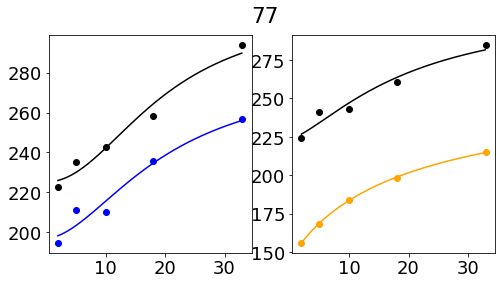

77
3.4156917275091367 1.5840178180251163 1.7982199994214414 0.1999999999999783
7.446842116835306 6.4792435441426655 7.033448661323494 4.932048068211081 7.446842116835306


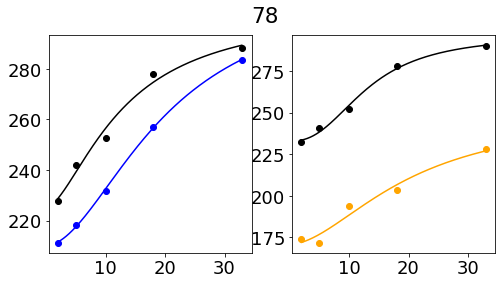

78
3.448174287303133 1.6103166969520912 2.1990060852391724 0.19999999999999998
6.426475001769916 6.663007856533021 8.268060436650693 5.480103682948734 8.268060436650693


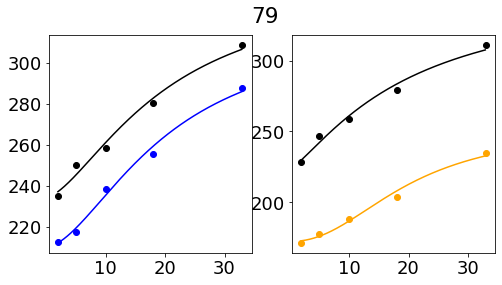

79
3.430993844899355 1.2846235449233865 1.8647730777321379 0.1330283619151826
8.10344082580814 9.222733894314405 6.734965403766147 6.072658583918544 9.222733894314405


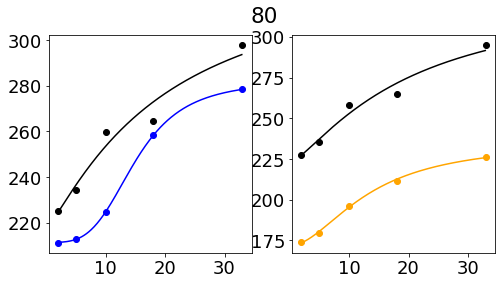

80
3.4121942305255737 1.8606196677883517 1.5149039732437952 0.19999999999999998
11.563894269011232 6.059344775102371 11.10217482701703 5.652930258841238 11.563894269011232


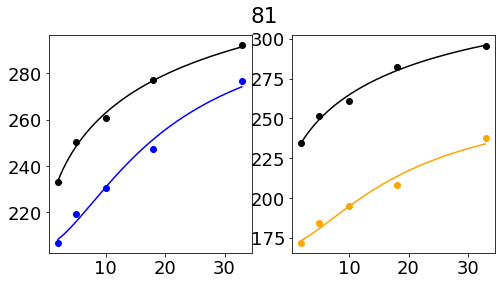

81
3.57154502306255 1.9352565615627666 1.4873838086009392 0.19999999999999993
6.6027743407937045 6.661712795599595 8.07259905045452 5.893781926196073 8.07259905045452


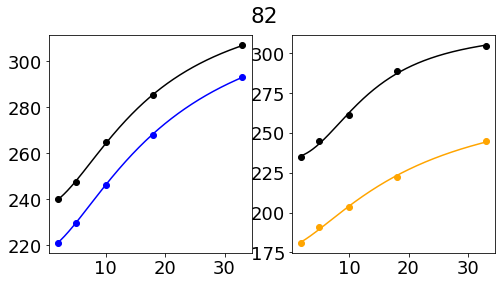

82
3.3686525611846565 0.9666840722264831 3.1659466266543186 0.15343101829808234
6.585954034354646 7.319615355632614 7.127396263649555 5.512767712126676 7.319615355632614


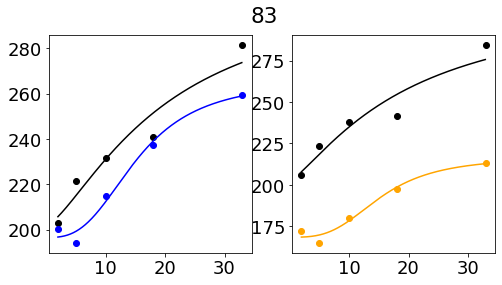

83
3.328140084923111 1.3346507034058457 2.1921822055216156 0.09208604024010626
10.472471929520921 12.043861293102687 8.655133047522057 9.792644859766986 12.043861293102687


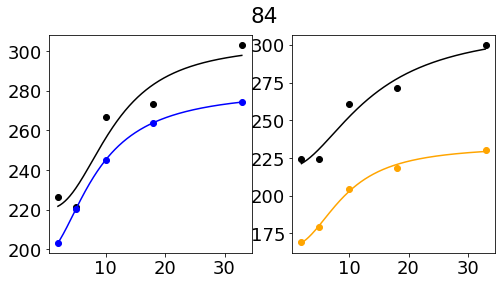

84
3.4399540805279125 1.4815985120661648 2.818628321809418 0.19999999999999998
5.851666358723673 8.593522177886204 5.356234793305159 5.932512545468249 8.593522177886204


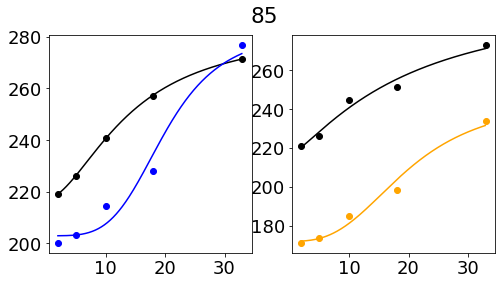

85
3.442940726426573 1.8501552587776995 1.6967203062696934 0.19999999999999998
6.157934449189195 6.998616578662897 7.843583706266255 5.676051489537093 7.843583706266255


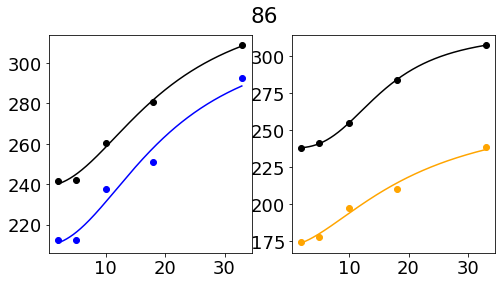

86
3.64096172286643 1.5606623481390813 1.9054757670456117 0.19999999999999998
6.986628439562459 6.5003318490001405 7.830009853847475 4.960493967088286 7.830009853847475


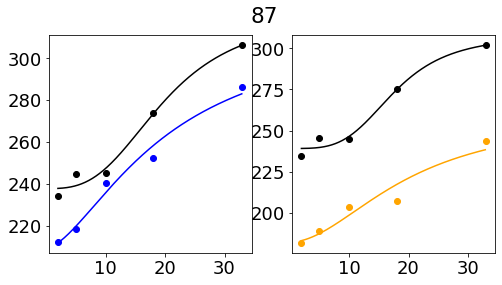

87
3.5081797511372126 1.6644420338959713 1.6324386161608058 0.19999999999999982
6.014401654465384 5.89470590390393 7.1553322408908215 5.079804389328935 7.1553322408908215


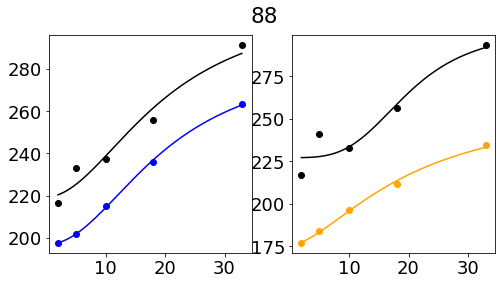

88
3.211222211863298 1.9054933571813881 1.2050005736734537 0.19999999999986443
6.328520115842995 10.175709774115926 6.245232421434466 6.397722295180319 10.175709774115926


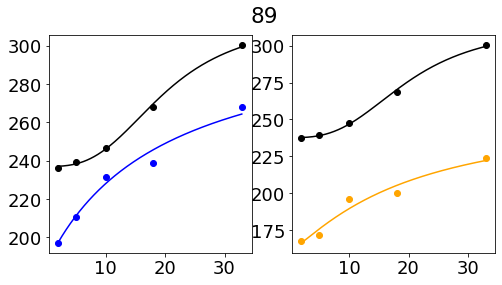

89
3.519693507838924 1.5498726162156355 2.4369780922134843 0.19999999999999934
8.047737145913736 7.144401574208015 7.20659232410874 5.603881241027953 8.047737145913736


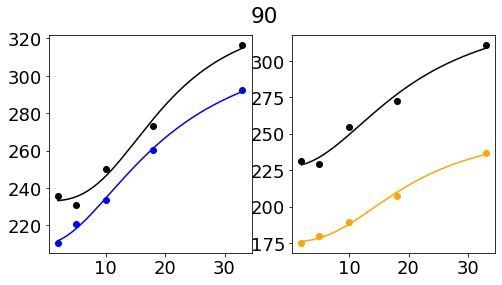

90
3.301588008823007 1.968502687464727 1.0076295412926422 0.19999999999999965
5.18474973411589 14.949047082997424 5.343827145186353 7.74295779136871 14.949047082997424


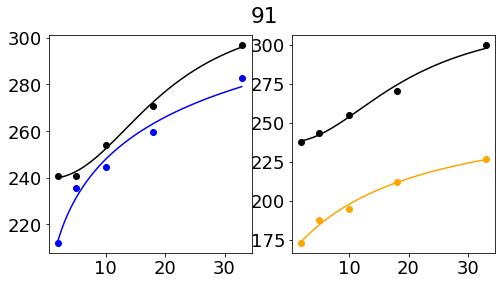

91
3.3925082584428377 1.8044065273403553 2.0210070783589082 0.1719302350824625
6.7417239051761335 7.799121792301911 5.575476539631641 6.835163436127267 7.799121792301911


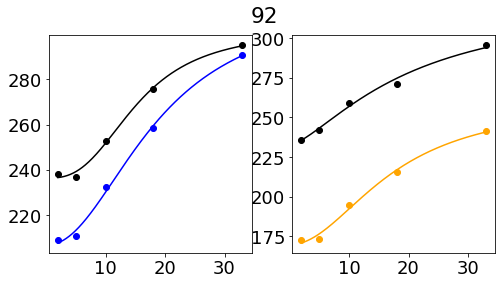

92
3.5088553426933755 1.567705620720051 2.21655073583822 0.19999999999999998
6.766817391188429 6.820805274159891 6.777476501009971 5.356505141147672 6.820805274159891


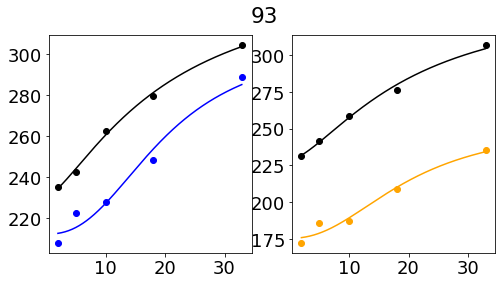

93
2.4021997104577526 3.642185817384616 0.5305769387542384 0.19999999999977464
8.679213387512963 17.50959868029991 11.743569412090604 14.573965344803996 17.50959868029991


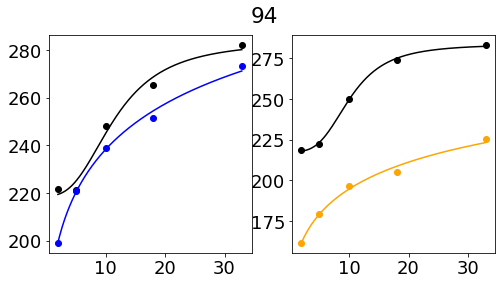

94
3.6010683750475407 1.6109990810259325 2.3017567113062674 0.19999999999999998
9.325908822045914 6.812904968912203 9.015420304599253 5.630657349488644 9.325908822045914


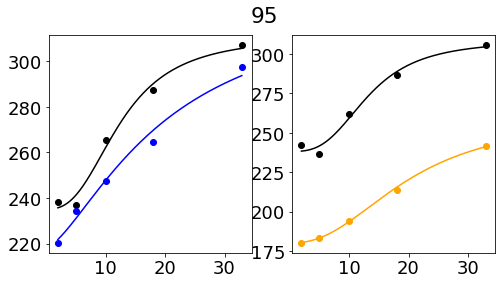

95
3.5564163730443354 1.4741449753771183 2.7020206114011436 0.15398026530789846
8.955034482287605 7.223067221648893 7.212820591138147 7.433329666692723 8.955034482287605


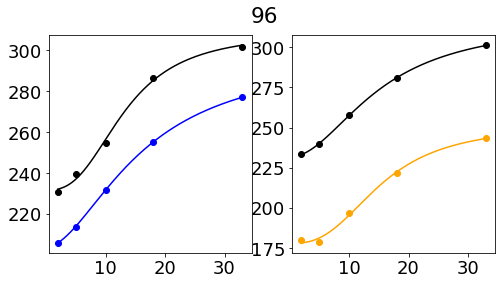

96
3.588502201200068 1.159969352342723 4.2890429723397165 0.19999999999999998
5.6310197534023665 6.464505624711858 5.729924975674372 6.547292319923814 6.547292319923814


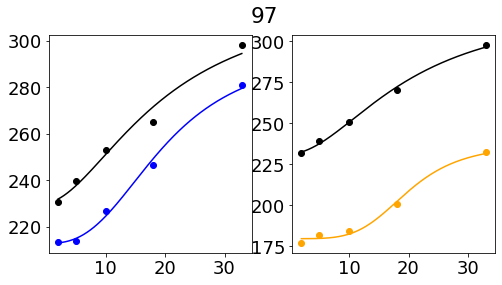

97
3.4469960873249166 1.2416518797982594 2.6517520797497336 0.10256748574743672
6.692552841589627 6.660565093871096 7.440321528436833 9.261572519473704 9.261572519473704


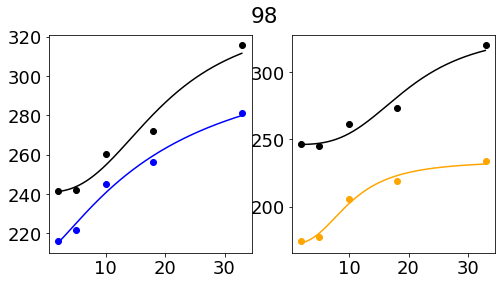

98
3.461929935958542 1.5788094978893765 2.094635300514344 0.16492228190733818
7.566563958590677 8.997978840784615 8.165334867587681 6.341836570592596 8.997978840784615


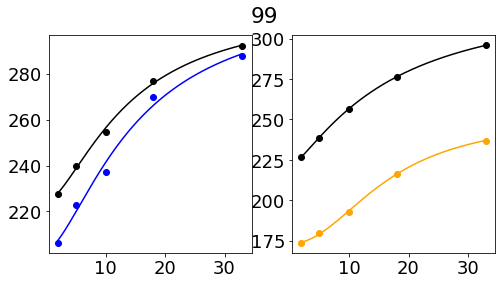

99
3.4009202615508185 1.5314514081454564 1.8538277292980487 0.11962702651498705
6.285952662724714 9.36063763227688 6.546512465452192 8.047521376372035 9.36063763227688


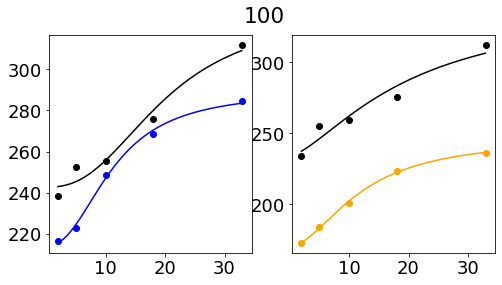

100


In [119]:
simname = 'base3t'
contrasts = np.array([0.02, 0.05, 0.1, 0.18, 0.33])
# contrasts = np.array([0.02, 0.05, 0.1, 0.18])
ignor=0
slopes_cp, slopes_sp, slopes_cs, slopes_ss = [], [], [], []
binlen = 60

ctrl_pv_ave = np.zeros(5)
stim_pv_ave = np.zeros(5)
ctrl_sst_ave = np.zeros(5)
stim_sst_ave = np.zeros(5)

parameter_fits = []

for seed in range(1,101):
    # contrasts = np.array([0.02, 0.05, 0.2, 0.3])
    # contrasts = np.array([0.02,  0.2])
    ctrl_pv_curve = [[] for i in range(4)]
    stim_pv_curve = [[] for i in range(4)]
    ctrl_sst_curve = [[] for i in range(4)]
    stim_sst_curve = [[] for i in range(4)]

    ctrl_pv_curve_e = [[] for i in range(4)]
    stim_pv_curve_e = [[] for i in range(4)]
    ctrl_sst_curve_e = [[] for i in range(4)]
    stim_sst_curve_e = [[] for i in range(4)]

    
    folder = 'data/%s/results_%s/'%(simname, seed)
    not_all_found=False
    for ci, cont in enumerate(contrasts):
        try:
            with open(folder + 'PV_%s_spikes.pickle'%cont, 'rb') as f:
                all_spikes = pickle.load(f)
            with open(folder + 'PV_%s_positions.pickle'%cont, 'rb') as f:
                all_positions = pickle.load(f)
        except FileNotFoundError:
            not_all_found = True
            break

        ctrlpv_E_mean, stimpv_E_mean, ctrlpv_E_err, stimpv_E_err = getStimRateMeans(all_spikes[:8000], all_positions[:8000], binlen=binlen)
        ctrlpv_P_mean, stimpv_P_mean, ctrlpv_P_err, stimpv_P_err = getStimRateMeans(all_spikes[8000:9000], all_positions[8000:9000], binlen=binlen)
        ctrlpv_S_mean, stimpv_S_mean, ctrlpv_S_err, stimpv_S_err = getStimRateMeans(all_spikes[9000:10000], all_positions[9000:10000], binlen=binlen)
        ctrlpv_A_mean, stimpv_A_mean, ctrlpv_A_err, stimpv_A_err = getStimRateMeans(all_spikes, all_positions, binlen=binlen)

        ctrl_pv_curve[0].append(ctrlpv_E_mean)
        ctrl_pv_curve[1].append(ctrlpv_P_mean)
        ctrl_pv_curve[2].append(ctrlpv_S_mean)
        ctrl_pv_curve[3].append(ctrlpv_A_mean)
        ctrl_pv_curve_e[0].append(ctrlpv_E_err)
        ctrl_pv_curve_e[1].append(ctrlpv_P_err)
        ctrl_pv_curve_e[2].append(ctrlpv_S_err)
        ctrl_pv_curve_e[3].append(ctrlpv_A_err)

        stim_pv_curve[0].append(stimpv_E_mean)
        stim_pv_curve[1].append(stimpv_P_mean)
        stim_pv_curve[2].append(stimpv_S_mean)
        stim_pv_curve[3].append(stimpv_A_mean)
        stim_pv_curve_e[0].append(stimpv_E_err)
        stim_pv_curve_e[1].append(stimpv_P_err)
        stim_pv_curve_e[2].append(stimpv_S_err)
        stim_pv_curve_e[3].append(stimpv_A_err)
        


        try:
            with open(folder + 'SOM_%s_spikes.pickle'%cont, 'rb') as f:
                all_spikes = pickle.load(f)
            with open(folder + 'SOM_%s_positions.pickle'%cont, 'rb') as f:
                all_positions = pickle.load(f)
        except FileNotFoundError:
            not_all_found = True
            break

        ctrlsst_E_mean, stimsst_E_mean, ctrlsst_E_err, stimsst_E_err = getStimRateMeans(all_spikes[:8000], all_positions[:8000], binlen= binlen)
        ctrlsst_P_mean, stimsst_P_mean, ctrlsst_P_err, stimsst_P_err = getStimRateMeans(all_spikes[8000:9000], all_positions[8000:9000], binlen= binlen)
        ctrlsst_S_mean, stimsst_S_mean, ctrlsst_S_err, stimsst_S_err = getStimRateMeans(all_spikes[9000:10000], all_positions[9000:10000], binlen= binlen)
        ctrlsst_A_mean, stimsst_A_mean, ctrlsst_A_err, stimsst_A_err = getStimRateMeans(all_spikes, all_positions, binlen= binlen)


        ctrl_sst_curve[0].append(ctrlsst_E_mean)
        ctrl_sst_curve[1].append(ctrlsst_P_mean)
        ctrl_sst_curve[2].append(ctrlsst_S_mean)
        ctrl_sst_curve[3].append(ctrlsst_A_mean)
        ctrl_sst_curve_e[0].append(ctrlsst_E_err)
        ctrl_sst_curve_e[1].append(ctrlsst_P_err)
        ctrl_sst_curve_e[2].append(ctrlsst_S_err)
        ctrl_sst_curve_e[3].append(ctrlsst_A_err)

        stim_sst_curve[0].append(stimsst_E_mean)
        stim_sst_curve[1].append(stimsst_P_mean)
        stim_sst_curve[2].append(stimsst_S_mean)
        stim_sst_curve[3].append(stimsst_A_mean)
        stim_sst_curve_e[0].append(stimsst_E_err)
        stim_sst_curve_e[1].append(stimsst_P_err)
        stim_sst_curve_e[2].append(stimsst_S_err)
        stim_sst_curve_e[3].append(stimsst_A_err)
    # contrasts = np.array([ 0.05, 0.1, 0.2, 0.3])
    
        ctrl_pv_ave[ci] += ctrlpv_A_mean
        stim_pv_ave[ci] += stimpv_A_mean
        ctrl_sst_ave[ci] += ctrlsst_A_mean
        stim_sst_ave[ci] += stimsst_A_mean
    
    if not_all_found:
        continue
#     continue
        
    params, cov = fit_naka_rushton(contrasts[ignor:], ctrl_pv_curve[3][ignor:], sigma=ctrl_pv_curve_e[3][ignor:])
    m_cp, C_cp, n_cp, k_cp = params
    m_cp_err, C_cp_err, n_cp_err, k_cp_err = np.sqrt(np.diag(cov))
#     slope_cp = C_cp*n_cp/k_cp/4.0
    slope_cp, _ = get_slope(m_cp, C_cp, n_cp, k_cp)
    
    params, cov = fit_naka_rushton(contrasts[ignor:], stim_pv_curve[3][ignor:], sigma=stim_pv_curve_e[3][ignor:])
    m_sp, C_sp, n_sp, k_sp = params
    m_sp_err, C_sp_err, n_sp_err, k_sp_err = np.sqrt(np.diag(cov))
#     slope_sp = C_sp*n_sp/k_sp/4.0
    slope_sp, _ = get_slope(m_sp, C_sp, n_sp, k_sp)
    
    params, cov = fit_naka_rushton(contrasts[ignor:], ctrl_sst_curve[3][ignor:], sigma=ctrl_sst_curve_e[3][ignor:])
    m_cs, C_cs, n_cs, k_cs = params
    m_cs_err, C_cs_err, n_cs_err, k_cs_err = np.sqrt(np.diag(cov))
#     slope_cs = C_cs*n_cs/k_cs/4.0
    slope_cs, _ = get_slope(m_cs, C_cs, n_cs, k_cs)
    
    params, cov = fit_naka_rushton(contrasts[ignor:], stim_sst_curve[3][ignor:], sigma=stim_sst_curve_e[3][ignor:])
    m_ss, C_ss, n_ss, k_ss = params
    m_ss_err, C_ss_err, n_ss_err, k_ss_err = np.sqrt(np.diag(cov))
#     slope_ss = C_ss*n_ss/k_ss/4.0
    slope_ss, _ = get_slope(m_ss, C_ss, n_ss, k_ss)
    
    
#     if np.max( [slope_cp, slope_sp, slope_cs, slope_ss] ) >50: continue
    slopes_cp.append(slope_cp)
    slopes_sp.append(slope_sp)
    slopes_cs.append(slope_cs)
    slopes_ss.append(slope_ss)
    
    print(m_ss, C_ss, n_ss, k_ss)
    parameter_fits.append([ m_cp, C_cp, n_cp, k_cp, m_sp, C_sp, n_sp, k_sp, m_cs, C_cs, n_cs, k_cs, m_ss, C_ss, n_ss, k_ss])
    
    print(slope_cp, slope_sp, slope_cs, slope_ss, np.max( [slope_cp, slope_sp, slope_cs, slope_ss] ) )
    
    scal = 50
    cvals = np.arange(0.02,0.33,0.001)
    fig,axes = plt.subplots(1,2,figsize = (8,4))
    axes[0].scatter(contrasts*100, np.array(ctrl_pv_curve[3])*scal, c='black')
    axes[0].scatter(contrasts*100, np.array(stim_pv_curve[3])*scal, c='blue')
    yvals = naka_rushton(cvals, m_cp, C_cp, n_cp, k_cp)
    axes[0].plot(cvals*100, yvals*scal, c='black')
    yvals = naka_rushton(cvals, m_sp, C_sp, n_sp, k_sp)
    axes[0].plot(cvals*100, yvals*scal, c='blue')
    
    axes[1].scatter(contrasts*100, np.array(ctrl_sst_curve[3])*scal, c='black')
    axes[1].scatter(contrasts*100, np.array(stim_sst_curve[3])*scal, c='orange')
    yvals = naka_rushton(cvals, m_cs, C_cs, n_cs, k_cs)
    axes[1].plot(cvals*100, yvals*scal, c='black')
    yvals = naka_rushton(cvals, m_ss, C_ss, n_ss, k_ss)
    axes[1].plot(cvals*100, yvals*scal, c='orange')
    plt.suptitle(seed)
    plt.show()
    
    print(seed)
    
ctrl_pv_ave = ctrl_pv_ave/100.
stim_pv_ave = stim_pv_ave/100.
ctrl_sst_ave = ctrl_sst_ave/100.
stim_sst_ave = stim_sst_ave/100.

In [120]:
with open('parameter_fits_base3t.pickle', 'wb') as f:
    pickle.dump(parameter_fits, f)

In [116]:
with open('parameter_fits_base3t.pickle', 'rb') as f:
    parameter_fits = pickle.load(f)

In [117]:
len(parameter_fits)

100

In [23]:
sstcolor = (0.898,0.6314,0.0039)
pvcolor = (0.0, 0.4039, 0.7059)

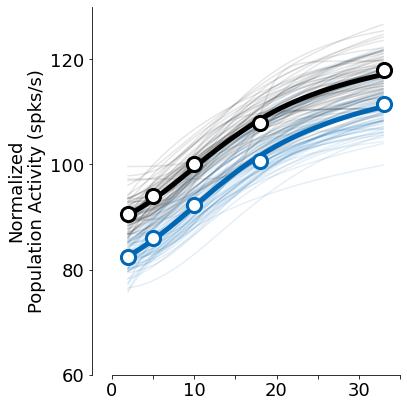

In [127]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (6,6))
cvals = np.arange(0.02,0.33,0.001)
ctrlave = np.zeros(len(cvals))
stimave = np.zeros(len(cvals))
scal = 20
for ti in range(65):
    m_cp, C_cp, n_cp, k_cp, m_sp, C_sp, n_sp, k_sp, m_cs, C_cs, n_cs, k_cs, m_ss, C_ss, n_ss, k_ss = parameter_fits[ti]

    
    yvals = naka_rushton(cvals, m_cp, C_cp, n_cp, k_cp)

    ax.plot(cvals,yvals*scal, c= 'black', alpha=0.1)
    
    ctrlave += yvals
    
    cvals = np.arange(0.02,0.33,0.001)
    yvals = naka_rushton(cvals, m_sp, C_sp, n_sp, k_sp)
    stimave += yvals

    ax.plot(cvals,yvals*scal, c= pvcolor, alpha=0.1)

    
ctrlave = ctrlave/65
stimave = stimave/65
ax.plot(cvals,stimave*scal, c=pvcolor, lw=5)
ax.plot(cvals,ctrlave*scal, c='black', lw=5)

ax.set_ylabel('Normalized\nPopulation Activity (spks/s)')
ax.set_yticks([60,80,100,120])
ax.set_ylim(60,130)

ax.scatter(contrasts, ctrl_pv_ave*scal, edgecolor='black', linewidth=3, s=200, facecolor = 'white', zorder=10)
ax.scatter(contrasts, stim_pv_ave*scal, edgecolor=pvcolor, linewidth=3, s=200, facecolor = 'white', zorder=10)


# ax.set_yticks([1*i for i in range(11)], [0,'',0.1,'',0.2,'',0.3,'',0.4, '',0.5])
# ax.set_ylim(0,9.)
# ax.set_xlim(-0.4,0.4)
ax.set_xlim(0.02,0.33)
ax.set_xticks([i*0.05 for i in range(8)])
ax.set_xticklabels([0,'',10,'',20,'',30,''])
sns.despine(offset={'left':20}, trim=False)

plt.tight_layout()

plt.savefig('PV_population_contrast.png', dpi=200)

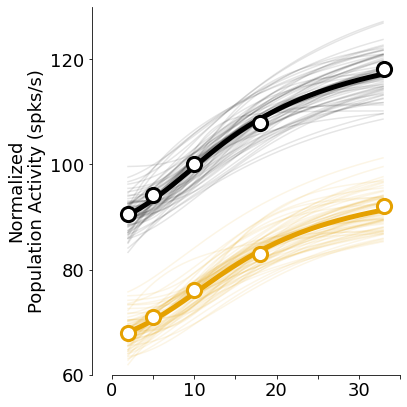

In [126]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (6,6))
cvals = np.arange(0.02,0.33,0.001)
ctrlave = np.zeros(len(cvals))
stimave = np.zeros(len(cvals))
scal = 20
for ti in range(65):
    m_cp, C_cp, n_cp, k_cp, m_sp, C_sp, n_sp, k_sp, m_cs, C_cs, n_cs, k_cs, m_ss, C_ss, n_ss, k_ss = parameter_fits[ti]

    
    yvals = naka_rushton(cvals, m_cs, C_cs, n_cs, k_cs)

    ax.plot(cvals,yvals*scal, c= 'black', alpha=0.1)
    
    ctrlave += yvals
    
    cvals = np.arange(0.02,0.33,0.001)
    yvals = naka_rushton(cvals, m_ss, C_ss, n_ss, k_ss)
    stimave += yvals

    ax.plot(cvals,yvals*scal, c= sstcolor, alpha=0.1)

    
ctrlave = ctrlave/65
stimave = stimave/65
ax.plot(cvals,stimave*scal, c=sstcolor, lw=5)
ax.plot(cvals,ctrlave*scal, c='black', lw=5)
ax.scatter(contrasts, ctrl_sst_ave*scal, edgecolor='black', linewidth=3, s=200, facecolor = 'white', zorder=10)
ax.scatter(contrasts, stim_sst_ave*scal, edgecolor=sstcolor, linewidth=3, s=200, facecolor = 'white', zorder=10)

ax.set_ylabel('Normalized\nPopulation Activity (spks/s)')
# ax.set_yticks([60,80,100,120,140])
ax.set_yticks([60,80,100,120])
ax.set_ylim(60,130)

# ax.set_yticks([1*i for i in range(11)], [0,'',0.1,'',0.2,'',0.3,'',0.4, '',0.5])
# ax.set_ylim(0,9.)
# ax.set_xlim(-0.4,0.4)
ax.set_xlim(0.02,0.33)
ax.set_xticks([i*0.05 for i in range(8)])
ax.set_xticklabels([0,'',10,'',20,'',30,''])
sns.despine(offset={'left':20}, trim=False)
plt.tight_layout()

plt.savefig('SST_population_contrast.png', dpi=200)

In [45]:
ctrl_sst_ave

array([2.01165548, 2.09174226, 2.22418858, 2.39803367, 2.6246376 ])